In [1]:
import cv2
import imutils
import numpy as np
import cupy as cp
import random
from os import listdir
from os.path import isfile, join
import io
from IPython.display import display
from PIL import Image
import time

#random.seed(19)

%run ./variables.ipynb
%run ./utils.ipynb

In [2]:
def ret_img(DATASET_PATH, min_img=9, max_img=12):
    images = []
    for path in DATASET_PATH:
        images.extend([(path, f) for f in listdir(path) if isfile(join(path, f))])
    n = random.randint(min_img, max_img)
    tmp_images = []
    for i in range(n):
        # CHOOSING RANDOM IMAGE
        img_path = random.choice(images)
        while(len(img_path[1].split('.'))<2 or img_path[1].split('.')[1]!='png'):
            img_path = random.choice(images)
        # LOADING THE IMAGE
        taxon = img_path[1].split('_')[1]
        img_path = join(img_path[0], img_path[1])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
        tmp_images.append({"data":img, "taxon":taxon})
    return tmp_images

In [29]:
def raw_generation(tmp_images, simple_angles = True, size_px = 1000, overlapping=False):
    art_img = (np.ones((size_px, size_px))).astype(np.uint8)
    global_patch = np.zeros_like(art_img)
    global_patch_mask = np.zeros_like(art_img)
    global_patch_mask_rogn = np.zeros_like(art_img)
    annotations = []
    z_step_counter = 0
    for img_obj in tmp_images:
        img = img_obj["data"]
        w, h = img.shape
        mask = np.ones_like(img)*255
        mask_rogn = round_rectangle(30, w, h, value=255)
        # ROTATING
        if simple_angles:
            angle = random.choice((0,90))
        else:
            angle = random.randint(0,360)

        rotated = imutils.rotate_bound(img, angle)
        rotated_mask = imutils.rotate_bound(mask, angle)
        rotated_mask_rogn = imutils.rotate_bound(mask_rogn, angle)
        #PLACING THE IMAGE WITHOUT OVERLAPPING
        overlap_test = 1
        n_stop = 200
        while overlap_test != 0 and n_stop != 0:
            # TRANSLATING
            px, py = int(rotated.shape[0]/2), int(rotated.shape[1]/2)
            x, y = random.randint(0,size_px-1), random.randint(0,size_px-1) 
            xmin, xmax, ymin, ymax = x-px, x+px, y-py, y+py
            dxmin, dxmax = (0, -xmin)[xmin<0], (0, size_px-1-xmax)[xmax>size_px-1]
            dymin, dymax = (0, -ymin)[ymin<0], (0, size_px-1-ymax)[ymax>size_px-1]
            # PLACING ON TEMPORARY PATCH/MASL
            patch = np.zeros_like(art_img)
            patch_mask = np.zeros_like(art_img)
            patch_mask_rogn = np.zeros_like(art_img)
            patch[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask[dxmin:2*px+dxmax, dymin:2*py+dymax]
            patch_mask_rogn[xmin+dxmin:xmax+dxmax, ymin+dymin:ymax+dymax] = rotated_mask_rogn[dxmin:2*px+dxmax, dymin:2*py+dymax]
            # Testing if there is overlapping by comparing to global mask
            if overlapping:
                break
            overlap_test = len(np.nonzero(np.logical_and(patch_mask, global_patch_mask))[0])
            n_stop -= 1
        if n_stop > 0:
            # (erosion to get rid of black edges)
            kernel_size = 3
            kernel = np.ones((kernel_size,kernel_size),np.uint8)
            patch_mask = cv2.erode(patch_mask,kernel,iterations = 1)
            patch_mask_rogn = cv2.erode(patch_mask_rogn,kernel,iterations = 1)
            # filling global patches
            cv2.copyTo(patch, patch_mask_rogn, global_patch)
            cv2.copyTo(patch_mask, patch_mask, global_patch_mask)
            cv2.copyTo(patch_mask_rogn, patch_mask_rogn, global_patch_mask_rogn)
            patch_mask_rogn[patch_mask_rogn>0]=1
            annotations.append({
                "taxon": img_obj["taxon"],
                "xmin": xmin+dxmin,
                "ymin": ymin+dymin,
                "xmax": xmax+dxmax,
                "ymax": ymax+dymax,
                "patch_mask": patch_mask_rogn,
                "z_index": z_step_counter
                
            })
            z_step_counter+=1
    #CREATING FINAL IMAGE
    cv2.copyTo(global_patch, global_patch_mask_rogn, art_img)
    return global_patch, global_patch_mask_rogn, annotations

In [30]:
def fast_img_filling(global_patch, global_patch_mask_rogn,sigma=10e3, verbose=False):
    final_img = cp.asarray(global_patch)
    # showImg(final_img)
    acc, accw = cp.zeros_like(final_img).astype(np.float64), cp.zeros_like(final_img).astype(np.float64)
    # Finding contours
    conts, h = cv2.findContours(global_patch_mask_rogn, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # Getting indices
    indices = cp.indices(final_img.shape)
    xMap = indices[0]
    yMap = indices[1]
    # Looping
    i = 0
    known = np.concatenate(conts)
    for kp in known:
        # Counter
        if verbose and i%2000==0:
            print(i, "/", len(known))
        i += 1
        # Init
        xkp, ykp = kp[0][1], kp[0][0]
        val = final_img[xkp, ykp]
        # FILLING
        d2 = cp.square(xMap - xkp) + cp.square(yMap - ykp)
        w = cp.exp(-d2/sigma)
        w[w<1e-9] = 1e-9
        acc += w*val
        accw += w
    acc = cp.divide(acc, accw)
    acc_img = acc.astype(np.uint8)
    tmp_global_patch_mask_null = cp.asarray(global_patch_mask_rogn)==0
    final_img[tmp_global_patch_mask_null]=acc_img[tmp_global_patch_mask_null]
    final_img = cp.asnumpy(final_img)
    return final_img

In [31]:
def blur_contours(final_image, annotations):
    # 01 - Creating border image
    pixels_to_blur = []
    contour_image = np.zeros_like(final_image)
    for annotation in annotations:
        mask = annotation["patch_mask"]
        z_index = annotation["z_index"]
        # Keeping overlapping pixels iff the image is on top
        for tmp_annotation in annotations:
            tmp_mask = tmp_annotation["patch_mask"]
            tmp_z_index = tmp_annotation["z_index"]
            if tmp_z_index>z_index:
                tmp_and = np.logical_and(mask, tmp_mask)
                if len(np.where(tmp_and!=0)[0]):
                    mask[tmp_mask!=0]=0
        conts, h = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for cont in conts:
            for kp in cont:
                xkp, ykp = kp[0][1], kp[0][0]
                max_xkp, max_ykp = final_image.shape
                if xkp>1 and ykp>1 and xkp<max_xkp-3 and ykp<max_ykp-3:
                    contour_image[xkp, ykp] = 1
    contour_image = cv2.dilate(contour_image, cv2.getStructuringElement(cv2.MORPH_RECT,(7,7)),iterations = 1)
    # 02 - Blurring borders
    kernel_size = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))/(kernel_size*kernel_size)
    final_image_blurred = cv2.filter2D(final_image,-1,kernel)
    final_image[contour_image!=0]=final_image_blurred[contour_image!=0]
    return final_image

In [32]:
def Generator_Img(DATASET_PATH, simple_angles = False, size_px = 1000, fast=False, verbose=False, overlapping=False):
    tmp_images = ret_img(DATASET_PATH, 9, 12)
    global_patch, global_patch_mask_rogn, annotations = raw_generation(tmp_images, simple_angles = simple_angles, size_px = size_px, overlapping=overlapping) 
    
    if fast: final_image = fast_img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    else: final_image = img_filling(global_patch, global_patch_mask_rogn, sigma=10e3, verbose=verbose)
    
    final_image = blur_contours(final_image, annotations)
    
    if verbose:
        print("Finished!")
        display(Image.fromarray(np.hstack([global_patch, global_patch_mask_rogn])))
        img_bb = final_image.copy()
        color = (255, 0, 0)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        for annotation in annotations:
            img_bb = cv2.rectangle(img_bb, (annotation["ymin"], annotation["xmin"]), (annotation["ymax"], annotation["xmax"]), color, 4)
            img_bb = cv2.putText(img_bb,  annotation["taxon"], (annotation["ymin"], annotation["xmin"]), font, fontScale, color, 6, cv2.LINE_AA) 
        display(Image.fromarray(img_bb))
    return final_image, annotations

0 / 5254
2000 / 5254
4000 / 5254
Finished!


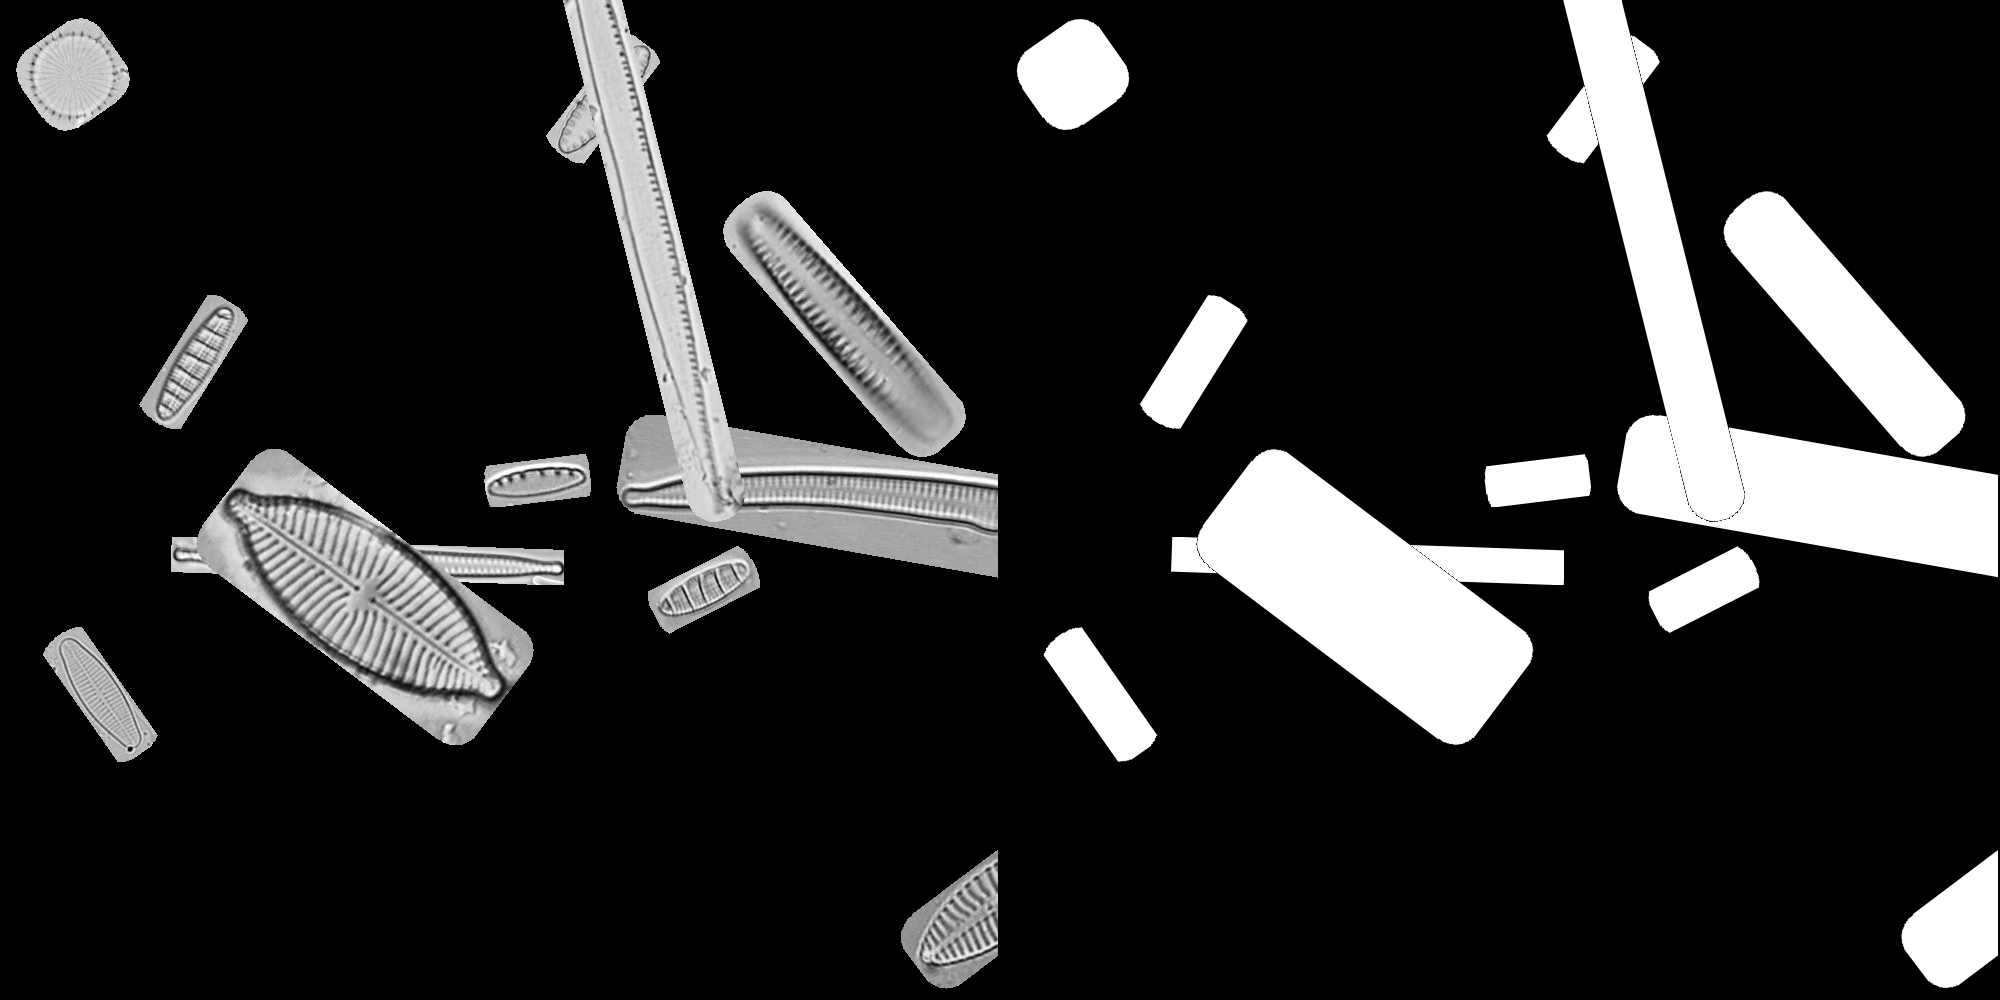

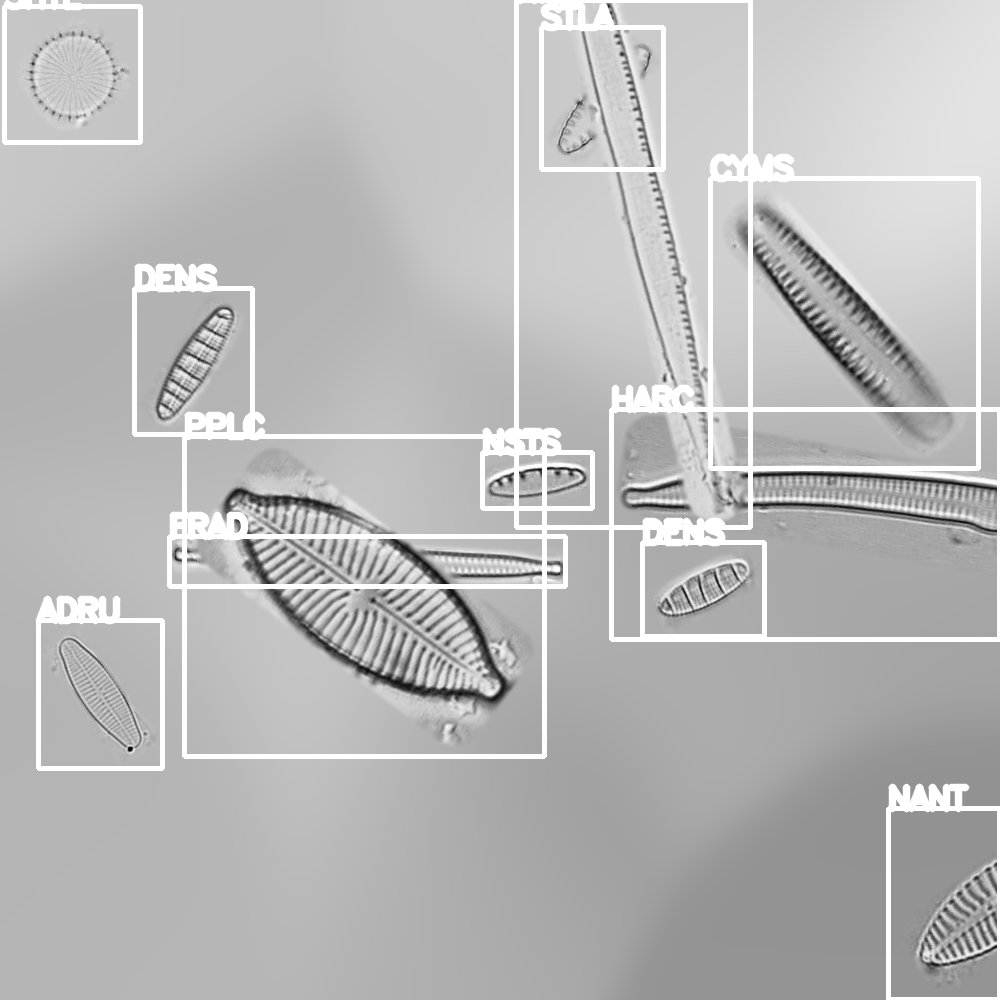

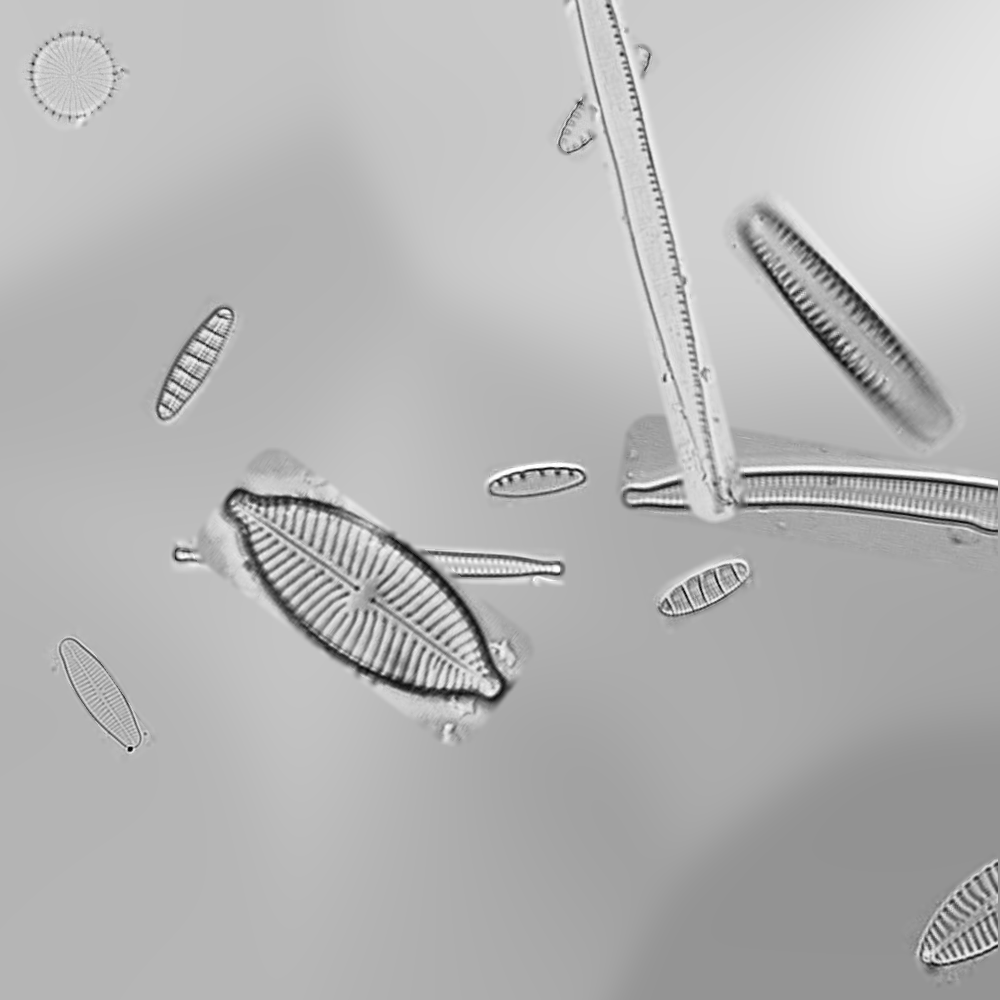

In [33]:
random.seed(25)
final_image, annotations = Generator_Img(DATASET_PATH, simple_angles = False, size_px = 1000, fast=True, verbose=True, overlapping=True)
display(Image.fromarray(final_image))